In [162]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.cross_validation import cross_val_score, KFold

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score, roc_curve, auc

from datetime import datetime


import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Set random seed

In [105]:
np.random.seed(1279)

## Majority Voting Classifier

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import operator

In [76]:
class MajorityVoteClassifier(BaseEstimator, ClassifierMixin):
    
    def __init__(self, classifiers, vote='classlabel', weights=None):
        
        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        
        self.vote = vote
        self.weights = weights
    
    def fit(self, X, y):
        
        self.labelenc_ = LabelEncoder()
        self.labelenc_.fit(y)
        self.classes_ = self.labelenc_.classes_
        self.classifiers_ = []
        
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.labelenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        
        return self
    
    def predict(self, X):
        
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X) for clf in self.classifiers_]).T
            
            maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(X, weights=self.weights)), 
                                           axis=1, arr=predictions)
            maj_vote = self.labelenc_.inverse_transform(maj_vote)
            return maj_vote
    
    def predict_proba(self, X):
        
        probas = np.asarray([clf.predict_proba(X) for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        
        return avg_proba
    
    def get_params(self, deep=True):
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in \
                six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(
                    step.get_params(deep=False)):
                    out['%s__%s' %(name, key)] = value
            return out

## Loading Files

In [ ]:
train = pd.read_csv('../data/train.csv', low_memory=False, parse_dates=['Earliest_Start_Date'])
students = pd.read_csv('../data/Student.csv')
internship = pd.read_csv('../data/Internship.csv')
test = pd.read_csv('../data/test.csv')

In [ ]:
# one_hot_encoded_skill_features = internship.columns[13:]
internship = internship[internship.columns.drop(one_hot_encoded_skill_features)]

## Merge with internship details

In [ ]:
train_with_internship = pd.merge(train, internship, how='left', on='Internship_ID')
test_with_internship = pd.merge(test, internship, how='left', on='Internship_ID')

## Merge with student details

In [ ]:
def feature_engineer(df):
    df['num_experience'] = df.shape[0]
    df['num_exp_in_job'] = (df.Experience_Type  == 'job').sum()
    df['num_awards'] = (df.Experience_Type  == 'award').sum()
    df['num_previous_internships'] = (df.Experience_Type == 'internship').sum()
    
    return df

students_cleaned = students.groupby('Student_ID').apply(feature_engineer)
students_cleaned = students_cleaned.groupby('Student_ID').first()
students_cleaned = students_cleaned.reset_index()

train_merged = pd.merge(train_with_internship, students_cleaned, on='Student_ID', how='left')
test_merged = pd.merge(test_with_internship, students_cleaned, on='Student_ID', how='left')

In [ ]:
# save these engineered files so that we don't have to create them every time
train_merged.to_csv('../data/train_merged.csv', index=False)
test_merged.to_csv('../data/test_merged.csv', index=False)

## Load prepared datasets

In [106]:
date_columns = ['Earliest_Start_Date', 'Start_Date', 'Start Date', 'End Date', 'Internship_deadline']

train_merged = pd.read_csv('../data/train_merged.csv', parse_dates=date_columns)
test_merged = pd.read_csv('../data/test_merged.csv', parse_dates=date_columns)

## Missing values

In [107]:
train_merged.Stipend1 = train_merged.Stipend1.fillna(train_merged.Stipend1.mean())

## Feature Engineering

In [108]:
# convert salary from numerical to categorical variable

def salary_mapping(salary):
    if salary < 2000:
        return 'No Expectations'
    elif salary >= 2000 and salary < 5000:
        return '2-5K'
    elif salary >= 5000 and salary < 10000:
        return '5-10K'
    else:
        return '10K+'

In [109]:
train_merged.loc[:, 'Stipend_level'] = train_merged.Stipend1.map(salary_mapping)
test_merged.loc[:, 'Stipend_level'] = test_merged.Stipend1.map(salary_mapping)

In [110]:
# utility function to get average stipend by year of graduation

def get_mean_stipend(df):
    year_of_grad = df['Year_of_graduation'].unique()
    mapping = {}
    
    for year in year_of_grad:
        mapping[year] = df[df['Year_of_graduation'] == year].Stipend1.mean()
    
    return mapping

train_map = get_mean_stipend(train_merged)
test_map = get_mean_stipend(test_merged)

In [111]:
# calculate expectation level to see if it matches with current experience of student

def calculate_expectation_level_train(row):
    year_of_grad = row['Year_of_graduation']
    mean_stipend = train_map[year_of_grad]
    stipend1 = row['Stipend1']
    
    return int ( stipend1 < mean_stipend ) 

def calculate_expectation_level_test(row):
    year_of_grad = row['Year_of_graduation']
    mean_stipend = test_map[year_of_grad]
    stipend1 = row['Stipend1']
    
    return int ( stipend1 < mean_stipend ) 


train_merged.loc[:, 'stipend_expectation_by_exp'] = train_merged.apply(calculate_expectation_level_train, axis=1)
test_merged.loc[:, 'stipend_expectation_by_exp'] = test_merged.apply(calculate_expectation_level_test, axis=1)

In [112]:
# match expectation

def check_if_expectations_match(row):
    expected_stipend = row['Expected_Stipend']
    stipend_level = row['Stipend_level']
    
    if expected_stipend == 'No Expectations':
        return 1
    elif expected_stipend == '2-5K':
        if stipend_level in ['2-5K', '5-10K', '10K+']:
            return 1
        else:
            return 0
    elif expected_stipend == '5-10K':
        if stipend_level in ['5-10K', '10K+']:
            return 1
        else:
            return 0
    elif expected_stipend == '10K+':
        if stipend_level == '10K+':
            return 1
        else:
            return 0

train_merged.loc[:, 'expectations_match'] = train_merged[['Expected_Stipend', 'Stipend_level']].apply(check_if_expectations_match, axis=1)
test_merged.loc[:, 'expectations_match'] = test_merged[['Expected_Stipend', 'Stipend_level']].apply(check_if_expectations_match, axis=1)

In [113]:
# map percentages to categorical variables

def percentage_to_grade(percentage):
    if percentage < 40.0:
        return 'F'
    elif percentage >= 40.0 and percentage < 50.0:
        return 'E'
    elif percentage >= 50.0 and percentage < 60.0:
        return 'D'
    elif percentage >= 60.0 and percentage < 70.0:
        return 'C'
    elif percentage >= 70.0 and percentage < 80.0:
        return 'B'
    else:
        return 'A'

In [114]:
# fix pg_performace by scale

def fix_pg_performance(row):
    scale = row['PG_scale']
    score = row['Performance_PG']
    
    if score == 10:
        return score * 10.
    else:
        return score

# fix ug_performace by scale

def fix_ug_performance(row):
    scale = row['UG_Scale']
    score = row['Performance_UG']
    
    if score == 10:
        return score * 10.
    else:
        return score

# fix percentages and then convert them to categorical variables
train_merged.loc[:, 'Performance_PG'] = train_merged.apply(fix_pg_performance, axis=1)
test_merged.loc[:, 'Performance_PG'] = test_merged.apply(fix_pg_performance, axis=1)

train_merged.loc[:, 'Performance_UG'] = train_merged.apply(fix_ug_performance, axis=1)
test_merged.loc[:, 'Performance_UG'] = test_merged.apply(fix_ug_performance, axis=1)


train_merged.loc[:, 'Performance_PG'] = train_merged.Performance_PG.map(percentage_to_grade)
test_merged.loc[:, 'Performance_PG'] = test_merged.Performance_PG.map(percentage_to_grade)

train_merged.loc[:, 'Performance_UG'] = train_merged.Performance_UG.map(percentage_to_grade)
test_merged.loc[:, 'Performance_UG'] = test_merged.Performance_UG.map(percentage_to_grade)

In [115]:
# convert 12th and 10th class percentages to categorical variables

train_merged.loc[:, 'Performance_12th'] = train_merged.Performance_12th.map(percentage_to_grade)
test_merged.loc[:, 'Performance_12th'] = test_merged.Performance_12th.map(percentage_to_grade)

train_merged.loc[:, 'Performance_10th'] = train_merged.Performance_10th.map(percentage_to_grade)
test_merged.loc[:, 'Performance_10th'] = test_merged.Performance_10th.map(percentage_to_grade)

In [116]:
# whether earliest start date month was in December or January
train_merged.loc[:, 'Earliest_Start_Date_month'] = train_merged.Earliest_Start_Date.dt.month
test_merged.loc[:, 'Earliest_Start_Date_month'] = test_merged.Earliest_Start_Date.dt.month

train_merged.loc[:, 'is_Dec_or_Jan'] = train_merged.Earliest_Start_Date_month.map(lambda x: int(x == 12 or x == 1))
test_merged.loc[:, 'is_Dec_or_Jan'] = test_merged.Earliest_Start_Date_month.map(lambda x: int(x == 12 or x == 1))

In [117]:
# student application count
application_count = train_merged.groupby('Student_ID').size()
application_count_test = test_merged.groupby('Student_ID').size()

train_merged.loc[:, 'whether_applied_previously'] = train_merged.Student_ID.map(lambda x: int( application_count.ix[x] > 1 ))
test_merged.loc[:, 'whether_applied_previously'] = test_merged.Student_ID.map(lambda x: int( application_count_test.ix[x] > 1 ))

In [118]:
# whether you have mentioned anything in your profile or not
train_merged.loc[:, 'missing_profile'] = train_merged.Profile.isnull().astype(np.int)
test_merged.loc[:, 'missing_profile'] = test_merged.Profile.isnull().astype(np.int)

In [119]:
# internship has mentioned skills required
train_merged.loc[:, 'missing_skills_required'] = train_merged.Skills_required.isnull().astype(np.int)
test_merged.loc[:, 'missing_skills_required'] = test_merged.Skills_required.isnull().astype(np.int)

## Label Encoding Categorical Features

In [121]:
categorical_features = train_merged.select_dtypes(include=['object']).columns

for feature in categorical_features:
    lbl = LabelEncoder()
    feature_range = pd.concat([train_merged[feature], test_merged[feature]], axis=0)
    
    lbl.fit(feature_range)
    train_merged.loc[:, feature] = lbl.transform(train_merged[feature])
    test_merged.loc[:, feature] = lbl.transform(test_merged[feature])

In [122]:
# fill missing value with 999

train_merged = train_merged.fillna(999)
test_merged = test_merged.fillna(999)

## Save dataset

In [216]:
train_merged.to_csv('../data/train_merged_encoded.csv', index=False)
test_merged.to_csv('../data/test_merged_encoded.csv', index=False)

## Data Preparation

In [123]:
features_to_drop = ['Earliest_Start_Date', 'Start_Date', 'Start Date', 'End Date',
                    'Is_Shortlisted', 'Internship_deadline', 'PG_scale', 'UG_Scale']

# features_to_drop.extend(list(train_merged.columns[20:293]))
features = train_merged.columns.drop(features_to_drop)

In [124]:
X = train_merged[features]
y = train_merged.Is_Shortlisted

In [125]:
# take a random sample of a given size
random_sample = np.random.randint(0, X.shape[0], size=15000)

In [126]:
X_train = X.iloc[random_sample]
y_train = y.iloc[random_sample]

In [127]:
# consider those internships which are not in the training set
test_index = X[~X.Internship_ID.isin(X_train.Internship_ID)].index

In [128]:
X_test = X.ix[test_index]
y_test = y.ix[test_index]

In [129]:
print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(15000, 315) (10212, 315) (15000,) (10212,)


## Classification pipeline

In [217]:
# feature selection
select = SelectKBest(chi2, k=60)

# feature scaling
scaler = StandardScaler()

# linear model
lr = LogisticRegression(C=1., penalty='l1')

# random forest classifier
rf = RandomForestClassifier(n_estimators=25, max_depth=4, min_samples_split=10, min_samples_leaf=10, n_jobs=-1)

# bagging classifier
bagging = BaggingClassifier(n_estimators=15, base_estimator=rf, n_jobs=-1)

# adaboost classifier
adaboost = AdaBoostClassifier(base_estimator=rf, n_estimators=50)

# gradient boosting machine
gbm = GradientBoostingClassifier(subsample=0.8, min_samples_split=10, min_samples_leaf=3)

# knn
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=-1)

pipe_lr = Pipeline([('select', select), ('scaler', scaler), ('clf', lr)])
pipe_rf = Pipeline([('select', select), ('clf', rf)])
pipe_bagging = Pipeline([('select', select), ('clf', bagging)])
pipe_adaboost = Pipeline([('select', select), ('clf', adaboost)])
pipe_gbm = Pipeline([('select', select), ('clf', gbm)])
pipe_knn = Pipeline([('select', select), ('scaler', scaler), ('clf', knn)])

In [218]:
clf_labels = ['Logistic Regression', 'Ada Boost Classifier', 'Gradient Boosting Machine']

## Cross validation

In [219]:
def cv(estimators, clf_labels, X, y, cv=3, train_size=10000):
    
    for clf, label in zip(estimators, clf_labels):
        scores = []
        for i in range(cv):
            train_index = np.random.permutation(train_size)

            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]

            test_index = X[~X.Internship_ID.isin(X_train.Internship_ID)].index

            X_test = X.ix[test_index]
            y_test = y.ix[test_index]
            
            clf.fit(X_train, y_train)
            
            predsTest = clf.predict_proba(X_test)[:, 1]
            score = roc_auc_score(y_test, predsTest)
            scores.append(score)
        
        print 'ROC AUC: %0.2f (+/- %0.2f) [%s]' %(np.mean(scores), np.std(scores), label)

In [220]:
cv([pipe_lr, pipe_bagging, pipe_gbm], clf_labels, X_train, y_train)

ROC AUC: 0.62 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.61 (+/- 0.00) [Ada Boost Classifier]
ROC AUC: 0.63 (+/- 0.01) [Gradient Boosting Machine]


In [221]:
## Add in our majority classifier
mv_clf = MajorityVoteClassifier(classifiers=[pipe_lr, pipe_bagging, pipe_gbm], weights=[0.2, 0.4, 0.4])

In [222]:
clf_labels += ['Majority Voting']

In [223]:
all_clfs = [pipe_lr, pipe_adaboost, pipe_gbm, mv_clf]

In [224]:
cv(all_clfs, clf_labels, X_train, y_train)

ROC AUC: 0.62 (+/- 0.00) [Logistic Regression]
ROC AUC: 0.62 (+/- 0.01) [Ada Boost Classifier]
ROC AUC: 0.62 (+/- 0.01) [Gradient Boosting Machine]
ROC AUC: 0.62 (+/- 0.00) [Majority Voting]


** Majority voting performs better than any of the individual classifiers **

In [213]:
mv_clf.fit(X_train, y_train)

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('select', SelectKBest(k=75, score_func=<function chi2 at 0x113107a28>)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10...    presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False))])],
            vote='classlabel', weights=[0.2, 0.4, 0.4])

## ROC curves

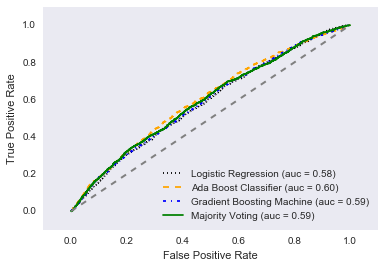

In [190]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

for clf, label, clr, ls \
        in zip(all_clfs, clf_labels, colors, linestyles):
    
    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' %(label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

## Feature Importance

In [172]:
# RF feature importance
forest = pipeline.get_params()['clf']
importances = forest.feature_importances_ 
indices = np.argsort(importances)[::-1] 

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X_train.columns[f], importances[indices[f]])) 

 1) Internship_ID                  0.116771
 2) Student_ID                     0.109342
 3) Minimum_Duration               0.080221
 4) Is_Part_Time                   0.069647
 5) Internship_Type                0.047877
 6) No_of_openings                 0.039503
 7) Stipend_Type                   0.038522
 8) Stipend1                       0.035383
 9) Internship_Duration(Months)    0.029671
10) PR                             0.028314
11) UI                             0.027536
12) Marketing                      0.026056
13) Media                          0.023554
14) Social                         0.019316
15) Design                         0.018387
16) Web                            0.016246
17) Development                    0.014927
18) Business                       0.014422
19) Research                       0.014019
20) Writing                        0.013950
21) Plan                           0.013721
22) Creative                       0.012162
23) Process                     

IndexError: index 100 is out of bounds for axis 0 with size 100

In [214]:
# GBM feature importance
forest = pipeline.get_params()['clf']
importances = forest.feature_importances_ 
indices = np.argsort(importances)[::-1] 

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, X_train.columns[f], importances[indices[f]])) 

 1) Internship_ID                  0.112838
 2) Student_ID                     0.110488
 3) Expected_Stipend               0.081714
 4) Minimum_Duration               0.073927
 5) Preferred_location             0.049659
 6) Is_Part_Time                   0.047065
 7) Internship_Type                0.040350
 8) Internship_Location            0.039712
 9) Internship_category            0.039164
10) No_of_openings                 0.038776
11) Stipend_Type                   0.037496
12) Stipend1                       0.029431
13) Internship_Duration(Months)    0.027383
14) Institute_Category             0.023922
15) Institute_location             0.021115
16) hometown                       0.020669
17) Stream                         0.019968
18) Current_year                   0.019587
19) Year_of_graduation             0.019051
20) Performance_PG                 0.018515
21) Performance_UG                 0.017904
22) Performance_12th               0.015356
23) Performance_10th            

## Predictions

In [214]:
predsTrain = (mv_clf.predict_proba(X_train)[:, 1])
predsTest = (mv_clf.predict_proba(X_test)[:, 1])

In [215]:
print 'AUC score on training set %f ' %(roc_auc_score(y_train, predsTrain))
print 'AUC score on test set %f ' %(roc_auc_score(y_test, predsTest))

AUC score on training set 0.748118 
AUC score on test set 0.587630 


## Train on full dataset

In [99]:
mv_clf.fit(X, y)

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None,...ki',
           metric_params=None, n_jobs=1, n_neighbors=7, p=2,
           weights='distance'))])],
            vote='classlabel', weights=[0.3, 0.5, 0.2])

## Predict on the test set

In [100]:
features_to_drop = ['Earliest_Start_Date', 'Start_Date', 'Start Date', 'End Date',
                    'Internship_deadline', 'Preferred_location', 'Internship_Profile', 
                    'Skills_required', 'Internship_category', 'Profile',
                    'Stipend2', 'PG_scale', 'UG_Scale', 'Internship_Location', 'Expected_Stipend',
                    'Degree', 'Stream', 'hometown', 'Institute_location', 'Location',
                    'Performance_12th', 'Performance_10th']

features_to_drop.extend(list(train_merged.columns[20:293]))
features = test_merged.columns.drop(features_to_drop)

In [101]:
test_features = test_merged[features]

In [102]:
predictions = (mv_clf.predict_proba(test_features)[:, 1])

In [103]:
submission = pd.read_csv('../data/submission.csv')
submission['Internship_ID'] = test_merged.Internship_ID
submission['Student_ID'] = test_merged.Student_ID
submission['Is_Shortlisted'] = predictions

In [104]:
submission.to_csv('../submissions/redate_submission_mv_clf.csv', index=False)